In [63]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split #spliting
from sklearn.preprocessing import StandardScaler,MinMaxScaler #Scaling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , accuracy_score
from sklearn.metrics import roc_curve, auc
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV

In [64]:
dataset = pd.read_csv('titanic.csv')
df_results = dataset.iloc[:,1].values
columns_to_exclude = [4, 9, 11]
selected_columns = [i for i in range(2, dataset.shape[1]) if i + 1 not in columns_to_exclude]
df_infos = dataset.iloc[:, selected_columns]
df_infos.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [65]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer.fit(df_infos.iloc[:, 2].values.reshape(-1, 1))
df_infos.iloc[:, 2] = imputer.transform(df_infos.iloc[:, 2].values.reshape(-1, 1))
df_infos.describe()
ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[1])],remainder='passthrough')
df_infos = np.array(ct.fit_transform(df_infos))
ct2 = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[-1])],remainder='passthrough')
df_infos = np.array(ct2.fit_transform(df_infos))

In [66]:
df_results_train , df_results_test , df_infos_train , df_infos_test = train_test_split(df_results, df_infos , test_size= 0.2, random_state= 1 )

In [67]:
'''
sc = StandardScaler() #Validação Cruzada: Média 0.805881614462369, Desvio Padrão 0.029275152914239093
df_infos_train = sc.fit_transform(df_infos_train)
df_infos_test = sc.transform(df_infos_test)
'''

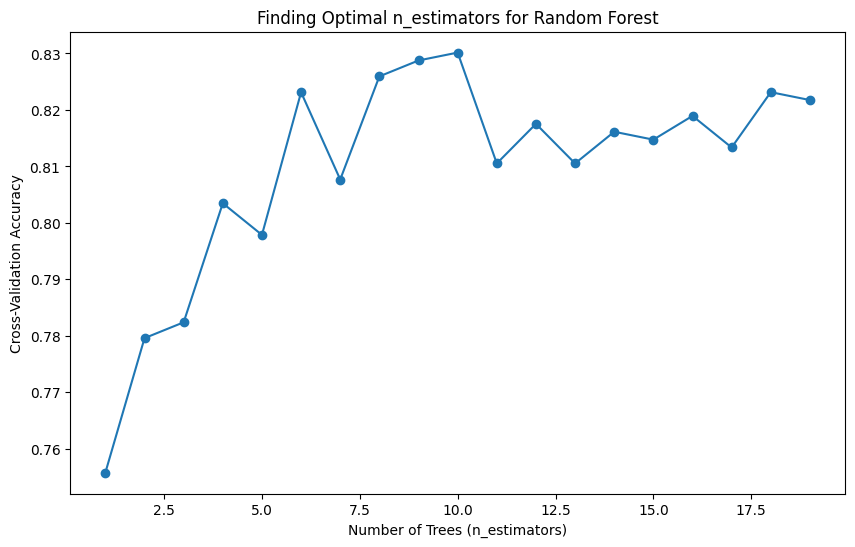

The optimal number of trees is 10


In [68]:
n_estimators_range = range(1, 20, 1)
cv_scores = []

for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    scores = cross_val_score(model, df_infos_train, df_results_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

cv_scores = np.array(cv_scores)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, cv_scores, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Finding Optimal n_estimators for Random Forest')
plt.show()

optimal_n_estimators = n_estimators_range[np.argmax(cv_scores)]
print(f'The optimal number of trees is {optimal_n_estimators}')

In [69]:
rf = RandomForestClassifier(n_estimators=optimal_n_estimators)
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(df_infos_train, df_results_train)
print(f'Melhores parâmetros: {grid_search.best_params_}')


Melhores parâmetros: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}


In [70]:
#classifier = DecisionTreeClassifier(criterion = 'entropy',ccp_alpha=0.01) #0.84
#classifier = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5) #0.85
classifier = RandomForestClassifier(n_estimators = optimal_n_estimators, max_depth = 30, max_features = 'sqrt', min_samples_leaf =  1, min_samples_split =  2)#0.97
#classifier = LogisticRegression(C=1,solver='lbfgs') #0.8
#classifier = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000) #0.8
#classifier = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)
#classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3) #0.91
#classifier = SVC(kernel='rbf', C=1.0, gamma='scale') #0.86
classifier.fit(df_infos_train,df_results_train)
pred_train = classifier.predict(df_infos_train)

In [71]:
scores = cross_val_score(classifier, df_infos, df_results, cv=5)
print(f'Validação Cruzada: Média {scores.mean()}, Desvio Padrão {scores.std()}')

Validação Cruzada: Média 0.8036093151716779, Desvio Padrão 0.01958448412945757


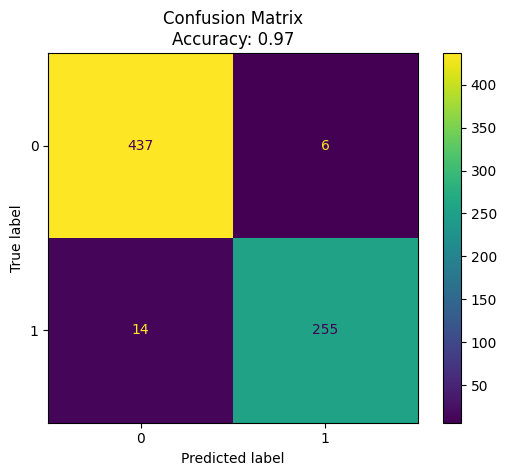

In [72]:
accuracy = accuracy_score(df_results_train, pred_train)
cm = confusion_matrix(df_results_train, pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
plt.show()

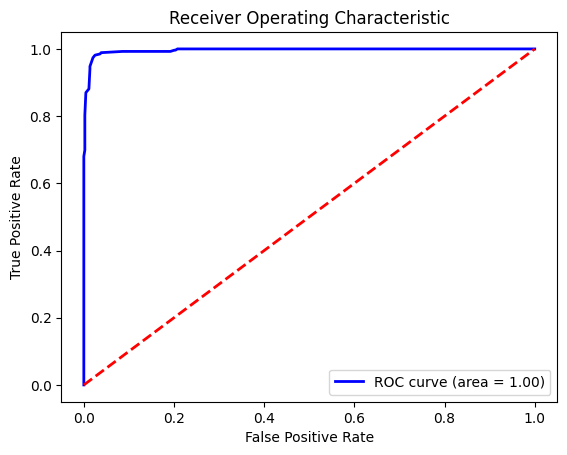

In [73]:
y_prob = classifier.predict_proba(df_infos_train)[:, 1]
fpr, tpr, thresholds = roc_curve(df_results_train, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

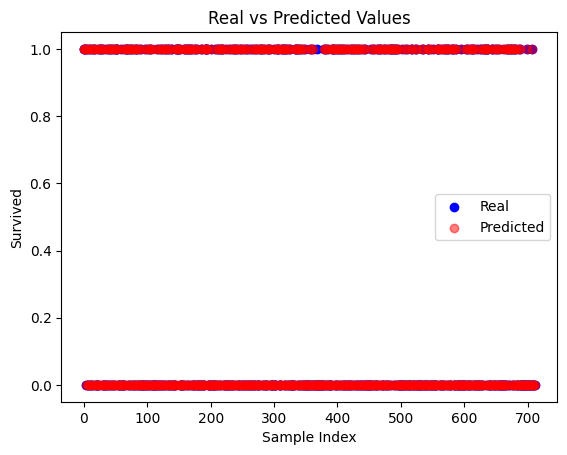

In [74]:
plt.scatter(range(len(df_results_train)), df_results_train, color='blue', label='Real')
plt.scatter(range(len(pred_train)), pred_train, color='red', alpha=0.5, label='Predicted')
plt.title('Real vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Survived')
plt.legend()
plt.show()


In [75]:
pred_test = classifier.predict(df_infos_test)

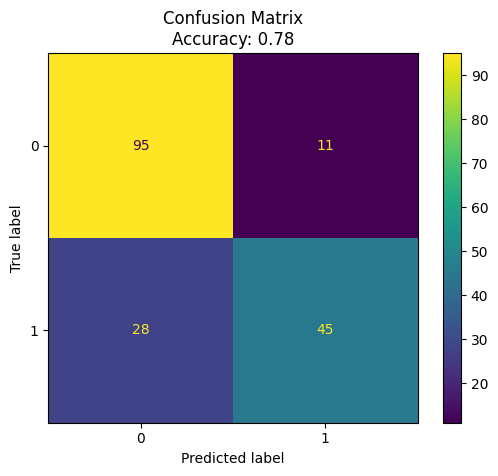

In [76]:
accuracy = accuracy_score(df_results_test, pred_test)
cm = confusion_matrix(df_results_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
plt.show()

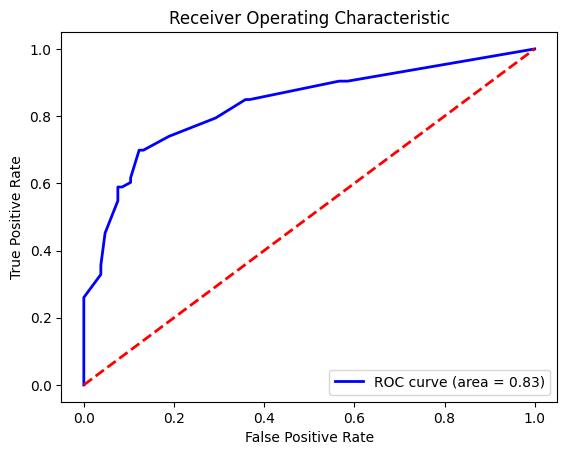

In [77]:
y_prob = classifier.predict_proba(df_infos_test)[:, 1]
fpr, tpr, thresholds = roc_curve(df_results_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

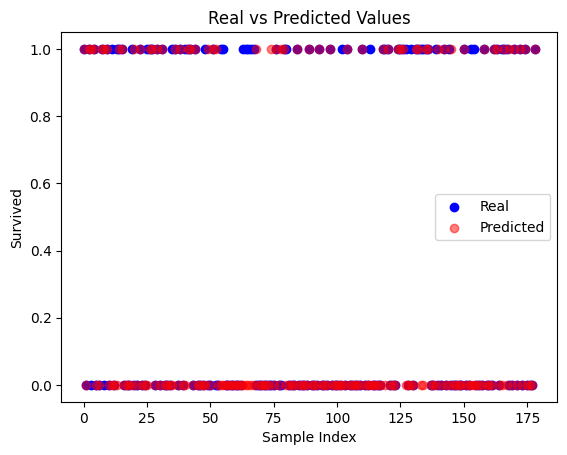

In [78]:
plt.scatter(range(len(df_results_test)), df_results_test, color='blue', label='Real')
plt.scatter(range(len(pred_test)), pred_test, color='red', alpha=0.5, label='Predicted')
plt.title('Real vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Survived')
plt.legend()
plt.show()